In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [4]:
#Import data

sheet_url = "https://docs.google.com/spreadsheets/d/1_LWErSQCdNm2O1r7ZxszgblbXNbrIDu3eBBDvkaJ_C0/edit?gid=1349519076"
sheet_id = sheet_url.split("/d/")[1].split("/")[0]
csv_export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid=1349519076"
df = pd.read_csv(csv_export_url)
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


## Remove contents that have user name "@..."

In [5]:
# remove user name
df = pd.DataFrame(df)

def content_reformat(text):
  tokens = text.split()
  if tokens and tokens[0].startswith('@'):
      tokens = tokens[1:]
  return ' '.join(tokens)

df['content'] = df['content'].apply(content_reformat)
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,i know i was listenin to bad habit earlier and...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,We want to trade with someone who has Houston ...


## Convert sentiment into categorical variables


In [6]:
df_convert = df.copy()
# categorical labels
df_convert['sentiment_label'] = df_convert['sentiment'].astype('category').cat.codes
# map to original content for refernce
map_label = dict(enumerate(df_convert['sentiment'].astype('category').cat.categories))
df_convert['sentiment'] = df_convert['sentiment_label'].map(map_label)
df_convert.head(100)


,tweet_id,sentiment,content,sentiment_label
0,1956967341,empty,i know i was listenin to bad habit earlier and...,2
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on...,10
2,1956967696,sadness,Funeral ceremony...gloomy friday...,10
3,1956967789,enthusiasm,wants to hang out with friends SOON!,3
4,1956968416,neutral,We want to trade with someone who has Houston ...,8
...,...,...,...,...
95,1956989514,sadness,hiii im on my ipod...i cant fall asleep,10
96,1956989526,sadness,dont wanna work 11-830 tomorrow but i get paid,10
97,1956989560,sadness,feels sad coz i wasnt able to play with the gu...,10
98,1956989561,neutral,PrinceCharming,8


## DistilBERT Implementation


In [7]:
import torch, math, random, itertools
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [8]:
seed = 21
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

| **Token** | **Purpose** |
|:----------:|-------------|
| `[CLS]` | The first token is always classification. |
| `[SEP]` | Separates two sentences. |
| `[END]` | Ends the sentence. |
| `[PAD]` | Used to pad the sentence to equal length. |
| `[MASK]` | Used to create a mask by replacing the original word. |

In [9]:
# train-test split
from sklearn.model_selection import train_test_split

In [10]:
# splits it into 80% training, 20% testing
sentence = df_convert['content'].tolist()
label = df_convert['sentiment_label'].tolist()


train_input, test_input, train_labels, test_labels = train_test_split(
    sentence, label, test_size = 0.2, random_state = 21)

In [11]:
# tokenization
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# tokenizing the training input
tokenizer_train = tokenizer(
    train_input,
    padding = True,
    truncation = True,
    return_tensors = 'pt',
    max_length = 128
)

# tokenizing the test input
tokenizer_test = tokenizer(
    test_input,
    padding = True,
    truncation = True,
    return_tensors = 'pt',
    max_length = 128
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
from datasets import Dataset

In [13]:
# converts the labels into PyTorch tensors
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

In [14]:
# BERT dataset
distilbert_train_ds = Dataset.from_dict({
    'input_ids': tokenizer_train['input_ids'],
    'attention_mask': tokenizer_train['attention_mask'],
    'labels': train_labels
})

distilbert_test_ds = Dataset.from_dict({
    'input_ids': tokenizer_test['input_ids'],
    'attention_mask': tokenizer_test['attention_mask'],
    'labels': test_labels
})
# stick with paper parameters 8, random seed 21, epoch 10, learning rate, 5e-5
train_loader = DataLoader(distilbert_train_ds, batch_size = 8, shuffle = True)
test_loader = DataLoader(distilbert_test_ds, batch_size = 8, shuffle = True)

## Visualize an example

In [15]:
batch = next(iter(train_loader))
input_ids_batch = batch['input_ids']
attention_mask_batch = batch['attention_mask']
labels_batch = batch['labels']

# Convert token IDs back to text
first_sentence_tokens = tokenizer.convert_ids_to_tokens(input_ids_batch[0])
first_sentence_text = tokenizer.decode(input_ids_batch[0], skip_special_tokens=True)

print("Token IDs:", input_ids_batch[0])
print("Tokens:", first_sentence_tokens)
print("Decoded text:", first_sentence_text)
print("Label:", labels_batch[0].item(), "->", map_label[labels_batch[0].item()])



Token IDs: tensor([101, 101, 101, 101, 101, 101, 101, 101])
Tokens: ['[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]']
Decoded text: 
Label: 8 -> neutral


## Training

In [16]:
# how many emotion classes we have
num_labels = len(map_label)

# downloads the DistilBERT weights, adds a classification head to be fine tuned on our data
distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

def performance_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [19]:
training_args = TrainingArguments(
    output_dir = './results',
    # overwrite_output_dir = True,
    learning_rate = 5e-5,
    eval_strategy = 'epoch',
    seed = seed,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    save_strategy = 'epoch',
    logging_dir = './logs',
    report_to = []
    )

trainer = Trainer(
    model = distilbert_model,
    args = training_args,
    train_dataset = distilbert_train_ds,
    eval_dataset = distilbert_test_ds,
    tokenizer = tokenizer,
    compute_metrics = performance_metrics
)

print("Starting training...")
train_output = trainer.train()

# Print training loss
print(f"Training loss: {train_output.training_loss}")
# Also evaluate to see eval loss after training
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)

trainer.save_model('./emotion_distilbert_final')
tokenizer.save_pretrained('./emotion_distilbert_final')
print("Model saved!")

/tmp/ipython-input-992591419.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.330000,2.027160,0.358625,0.345941,0.351015,0.358625
2,1.290000,2.042720,0.367750,0.350202,0.349116,0.367750


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training loss: 1.3799101104736329


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Eval metrics: {'eval_loss': 2.042720317840576, 'eval_accuracy': 0.36775, 'eval_f1': 0.3502016240696264, 'eval_precision': 0.34911584871068463, 'eval_recall': 0.36775, 'eval_runtime': 27.7876, 'eval_samples_per_second': 287.898, 'eval_steps_per_second': 35.987, 'epoch': 2.0}
Model saved!


## Confusion matrix visualization

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[  0   0   0   0   0   1   1   2   4   0   2   1  16]
 [  0   1   1   0   1   2   6   0   9   1  11   0   7]
 [  0   0   1   0   3  16  15   5  90   3  21  11  35]
 [  0   0   0   0   4  36   2  10  51   4  13   5  25]
 [  0   0   0   1  29 116   2  24 102   4  24  10  58]
 [  0   0   0   1  37 473   8 124 186  38  34  35  71]
 [  0   0   0   0   2  10  95   4  41   2  40   5  72]
 [  0   0   0   0  11 186  10 355  91  13  37  15  50]
 [  0   0   0   4  41 188  40  78 818  47 147  64 322]
 [  0   0   0   1   4  64   2  31  86  44  19   6  52]
 [  0   0   0   1  10  33  58  25 141  12 396  25 311]
 [  0   0   0   2  10  79  15  39 100   9  34  58 114]
 [  0   1   1   3  19  99  49  48 317  39 334  56 672]]


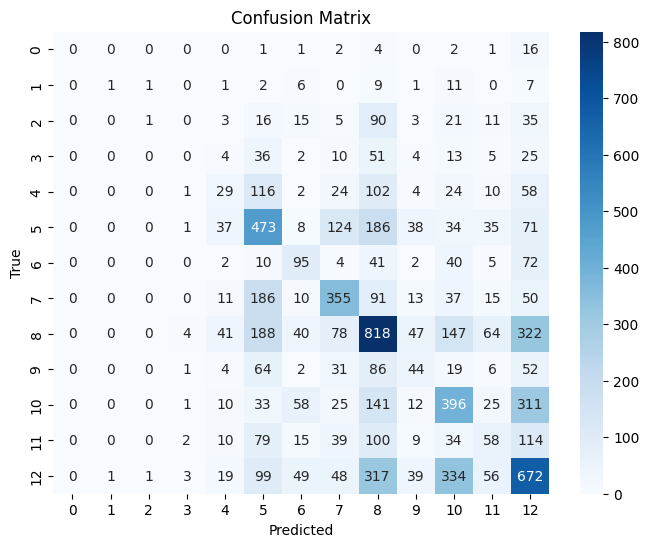

In [21]:
# get predictions
pred_output = trainer.predict(distilbert_test_ds)
# raw logit:
pred_prob = pred_output.predictions
# predicted labels
pred_label = pred_output.label_ids
prediction =np.argmax(pred_prob, axis = -1)

#confusion matrix
cm = confusion_matrix(test_labels, prediction)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [22]:
cls_report = classification_report(pred_label, prediction, target_names=map_label.values())
print(cls_report)

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        27
     boredom       0.50      0.03      0.05        39
       empty       0.33      0.01      0.01       200
  enthusiasm       0.00      0.00      0.00       150
         fun       0.17      0.08      0.11       370
   happiness       0.36      0.47      0.41      1007
        hate       0.31      0.35      0.33       271
        love       0.48      0.46      0.47       768
     neutral       0.40      0.47      0.43      1749
      relief       0.20      0.14      0.17       309
     sadness       0.36      0.39      0.37      1012
    surprise       0.20      0.13      0.15       460
       worry       0.37      0.41      0.39      1638

    accuracy                           0.37      8000
   macro avg       0.28      0.23      0.22      8000
weighted avg       0.35      0.37      0.35      8000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## User defined input


In [25]:
def user_input_prediction():
  user_input = input("Enter a sentence:" )
  user_input_tokenized = tokenizer(
    user_input,
    return_tensors = 'pt',
    truncation = True,
    padding = True
    )
  user_inputs = {k: v.to(trainer.model.device) for k, v in user_input_tokenized.items()}
  distilbert_model.eval()

  with torch.no_grad():
    logits = distilbert_model(**user_inputs).logits

    pred_label = torch.argmax(logits, dim=-1).item()
  print(f"Sentence: {user_input}")
  print(f"Predicted label: {pred_label}")


In [26]:
user_input_prediction()

Enter a sentence:I am happy
Sentence: I am happy
Predicted label: 7
